**DATA 620 Assignment: Document Classification**

Group members:  Mahmud Hasan Al Raji and Warner Alexis.

#Introduction

In this assignment, the goal is to build a model that can predict the class of new documents using the UCI Spambase dataset. By training the model on labeled emails and then testing it on unseen messages, we will evaluate how effectively the system identifies spam emails and supports real-world email filtering.

#Import Required Libraries

In this section we have imported all the required libraries for building and evaluating machine learning models. It includes tools for splitting the data, scaling features, creating pipelines, training classifiers (Logistic Regression, Random Forest, SVM, Neural Network, XGBoost), and computing key performance metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and classification reports. Visualization libraries like Matplotlib and Seaborn are also loaded for plotting results.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay
)
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Load and Inspect the Spambase Dataset


In this section, we have loaded the Spambase dataset from the UCI repository and separated the features (X) and labels (y). We have also printed the metadata and variable details to quickly understand the dataset structure. We have noticed that the Spambase dataset (UCI ID 94) contains 4,601 emails with 57 numeric features, including 48 word frequencies, 6 character frequencies, and 3 capital-letter patterns, used to classify emails as spam (1) or not spam (0). The data has no missing values and was collected from real inboxes. This dataset is widely used for testing spam-classification models such as logistic regression, SVM, neural networks, random forests, and XGBoost.

In [61]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
spambase = fetch_ucirepo(id=94)

# data (as pandas dataframes)
X = spambase.data.features
y = spambase.data.targets

# metadata
print(spambase.metadata)

# variable information
print(spambase.variables)


{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [62]:
X.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


Next, we have created a new dataframe by copying the features and adding the target column is_spam. Then we have checked the dataset shape, column names, and data types to understand the basic structure. After that, we have plotted the distribution of spam and non-spam emails to see how many messages belong to each class.

Dataset shape: (4601, 58)

 Columns: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail'] ...

 Data types:
float64    55
int64       3
Name: count, dtype: int64


/tmp/ipython-input-125455971.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_spam', data=df, palette="coolwarm")


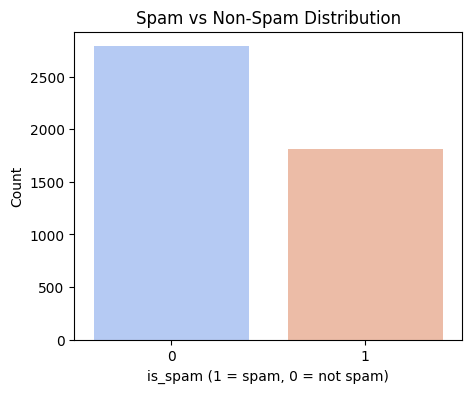

In [63]:
df = X.copy()
df['is_spam'] = y

# Basic info
print("Dataset shape:", df.shape)
print("\n Columns:", list(df.columns[:10]), "...")  # show a few
print("\n Data types:")
print(df.dtypes.value_counts())


# Target Variable Distribution

plt.figure(figsize=(5,4))
sns.countplot(x='is_spam', data=df, palette="coolwarm")
plt.title("Spam vs Non-Spam Distribution")
plt.xlabel("is_spam (1 = spam, 0 = not spam)")
plt.ylabel("Count")
plt.show()

This bar chart shows the **distribution of spam and non-spam emails** in the Spambase dataset. The x-axis represents the target variable `is_spam`, where **0 = non-spam (ham)** and **1 = spam**, while the y-axis shows the number of samples in each class. From the plot, we can see that there are **more non-spam emails (around 2,800)** than spam emails (around 1,800), meaning the dataset is **moderately imbalanced** but not severely so. This slight imbalance reflects a realistic scenario where legitimate emails are typically more common than spam. Such insight is important for model evaluation, as metrics like **precision, recall, and ROC AUC** should be used in addition to accuracy to ensure the classifier performs well on both classes.


Here we have checked the dataset for any missing values, and the result shows that there are none. After that, we have generated summary statistics to see basic information such as mean, standard deviation, and range for the features.

In [64]:
missing = df.isnull().sum()
print("\n Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found")

# Summary Statistics
print("\n Descriptive statistics:")
display(df.describe().T.head(10))


 Missing values per column:
No missing values found

 Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.0,0.0,0.00,4.54
word_freq_address,4601.0,0.213015,1.290575,0.0,0.0,0.0,0.00,14.28
word_freq_all,4601.0,0.280656,0.504143,0.0,0.0,0.0,0.42,5.10
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.0,0.0,0.00,42.81
word_freq_our,4601.0,0.312223,0.672513,0.0,0.0,0.0,0.38,10.00
word_freq_over,4601.0,0.095901,0.273824,0.0,0.0,0.0,0.00,5.88
word_freq_remove,4601.0,0.114208,0.391441,0.0,0.0,0.0,0.00,7.27
word_freq_internet,4601.0,0.105295,0.401071,0.0,0.0,0.0,0.00,11.11
word_freq_order,4601.0,0.090067,0.278616,0.0,0.0,0.0,0.00,5.26
word_freq_mail,4601.0,0.239413,0.644755,0.0,0.0,0.0,0.16,18.18


This descriptive statistics table summarizes the distribution of selected word-frequency features in the Spambase dataset, showing how often specific words appear across 4,601 emails. Each feature represents the percentage of times a given word occurs in an email. The mean values are generally low (mostly below 0.3), indicating that most words appear rarely, while the minimum and 25th–50th percentiles are zero, meaning many emails don’t contain these words at all. However, the large standard deviations and high maximum values (e.g., `word_freq_3d` up to 42.81 and `word_freq_address` up to 14.28) suggest that a few emails include these words very frequently. Overall, the data show a **right-skewed distribution**, typical of text-frequency datasets where most features are sparse but a few messages contain repeated keywords—an important pattern for detecting spam behavior.


#Data Visualizations

At first, we have selected the first six feature columns and plotted their histograms. This helps us quickly see the distribution of these sample features and understand how their values are spread across the dataset.

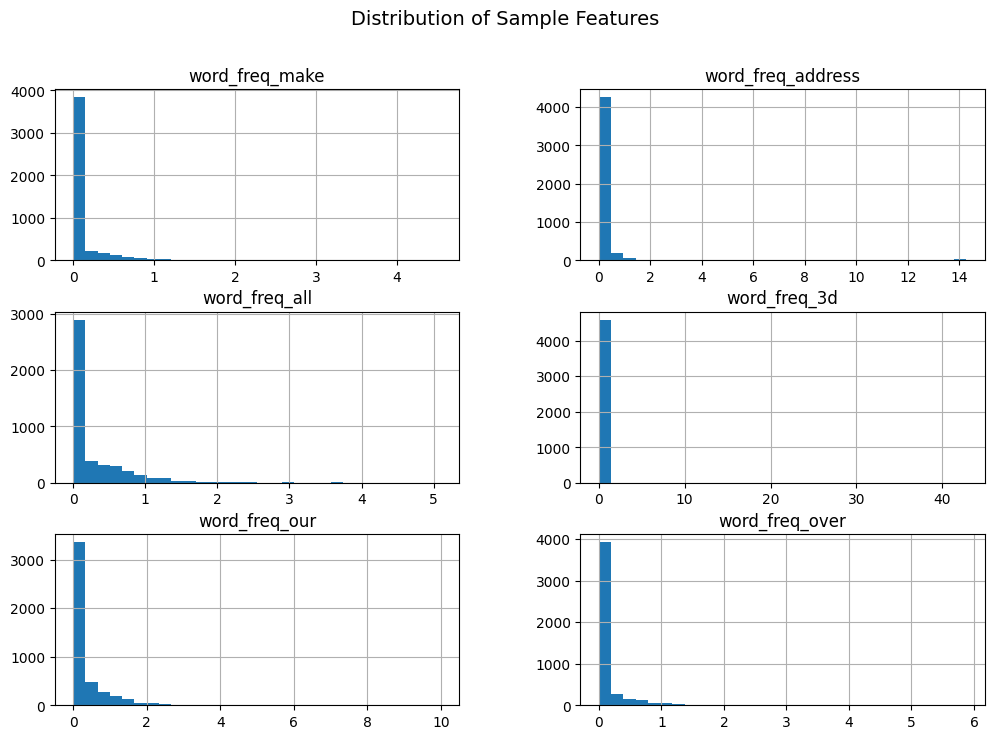

In [65]:
sample_cols = df.columns[:6]  # first 6 features
df[sample_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribution of Sample Features", fontsize=14)
plt.show()

Then we have calculated the skewness and kurtosis for all feature columns (excluding the target). This helps us understand how asymmetric each feature is and how heavy the tails are. Then we have printed the average skewness and kurtosis values to get an overall idea of how the dataset behaves statistically.

In [66]:
skewness = df.drop(columns='is_spam').skew().sort_values(ascending= False)
kurtosis = df.drop(columns='is_spam').kurt().sort_values(ascending=False)

In [67]:
print('\nAverage Skewness:', round(skewness.mean(),2))
print('\nAverage Kurtosis:', round(kurtosis.mean(),2))




Average Skewness: 11.19

Average Kurtosis: 241.17


Next, we have plotted a histogram of the skewness values for all features. This shows how the skewness is distributed across the dataset and helps us see that most features are right-skewed.

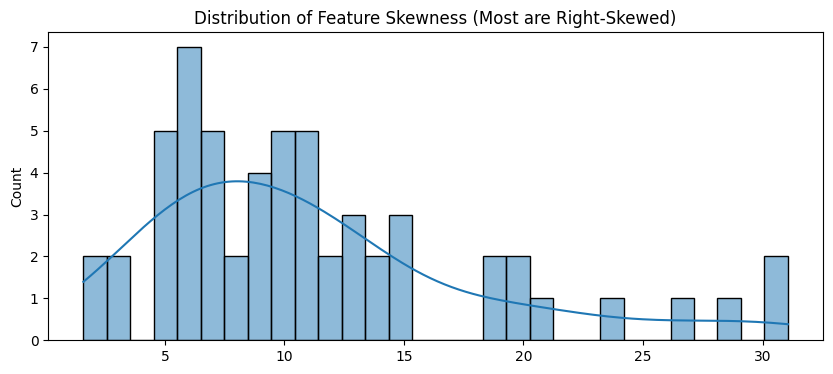

In [68]:
plt.figure(figsize=(10,4))
sns.histplot(skewness,bins=30, kde=True)
plt.title('Distribution of Feature Skewness (Most are Right-Skewed)')
plt.show()

Then we have selected the first six feature columns and plotted their histograms. This help us visualize how these sample word-frequency features are distributed and understand their overall spread in the dataset.

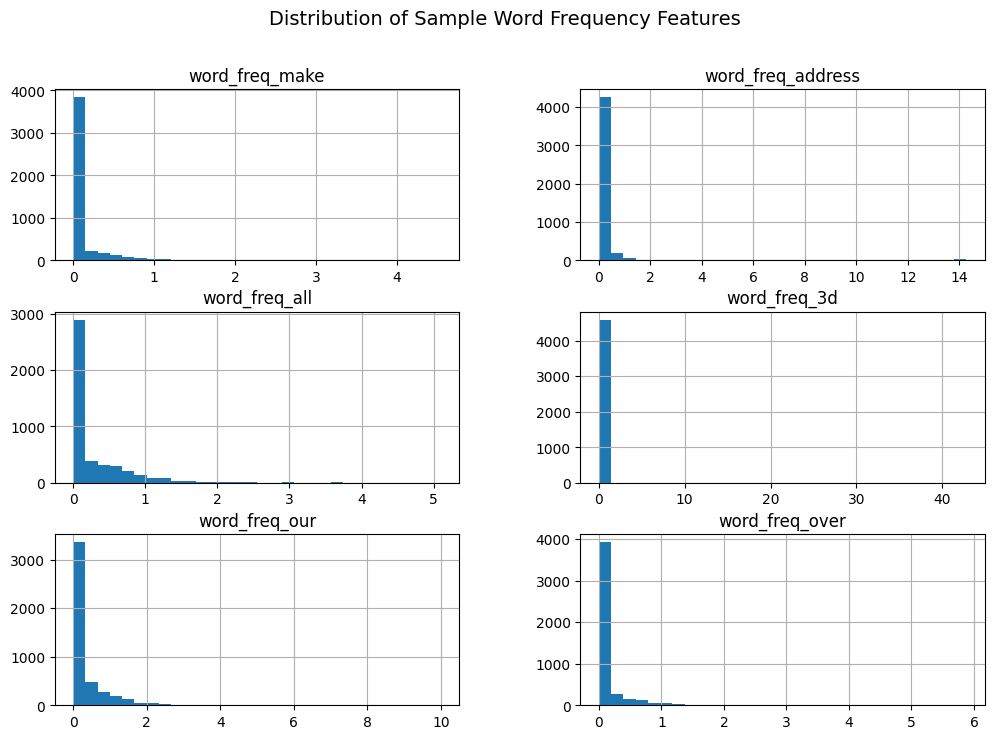

In [69]:
sample_cols = df.columns[:6]
df[sample_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribution of Sample Word Frequency Features", fontsize=14)
plt.show()

Next, we have calculated the correlation of every feature with the target variable is_spam. Then we have sorted the values to identify which features are most strongly associated with spam. After that, we have printed the top 10 features that have the highest positive correlation with spam and the top 10 features that have the strongest negative correlation. This helps us understand which words or patterns are most useful for predicting spam emails.

In [70]:
corr_target = df.corr()['is_spam'].sort_values(ascending=False)
print("\nTop 10 features positively correlated with Spam:")
print(corr_target.head(11))

print("\nTop 10 features negatively correlated with Spam:")
print(corr_target.tail(10))


Top 10 features positively correlated with Spam:
is_spam                     1.000000
word_freq_your              0.383234
word_freq_000               0.334787
word_freq_remove            0.332117
char_freq_$                 0.323629
word_freq_you               0.273651
word_freq_free              0.263215
word_freq_business          0.263204
capital_run_length_total    0.249164
word_freq_our               0.241920
char_freq_!                 0.241888
Name: is_spam, dtype: float64

Top 10 features negatively correlated with Spam:
word_freq_meeting   -0.136615
word_freq_re        -0.140408
word_freq_edu       -0.146138
word_freq_85        -0.149225
word_freq_650       -0.158800
word_freq_labs      -0.171095
word_freq_1999      -0.178045
word_freq_george    -0.183404
word_freq_hpl       -0.232968
word_freq_hp        -0.256723
Name: is_spam, dtype: float64


Then we have taken the absolute correlation values and selected the top 15 features most strongly related to the spam label. Then we have plotted them in a bar chart to easily see which features have the highest impact on predicting whether an email is spam or not.

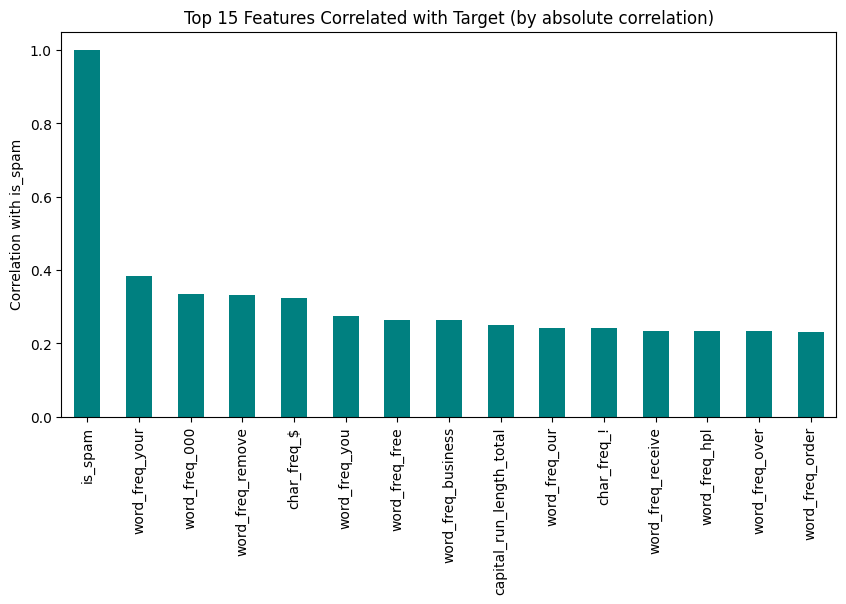

In [71]:
plt.figure(figsize=(10,5))
corr_target[:-1].abs().sort_values(ascending=False)[:15].plot(kind='bar', color='teal')
plt.title('Top 15 Features Correlated with Target (by absolute correlation)')
plt.ylabel('Correlation with is_spam')
plt.show()

The next step shows how the most important word-frequency features differ between spam and non-spam emails. The four density plots compare features like word_freq_your, word_freq_000, and word_freq_remove across the two classes. We can see that these words appear much more often in spam emails, which matches what we observed in the correlation analysis. This visualization helps confirm that certain keywords are strong indicators of spam and that the dataset has clear differences between spam and non-spam messages, supporting the development of effective classification models.


/tmp/ipython-input-3207016132.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue= 'is_spam', fill=True, common_norm=False, palette='coolwarm')


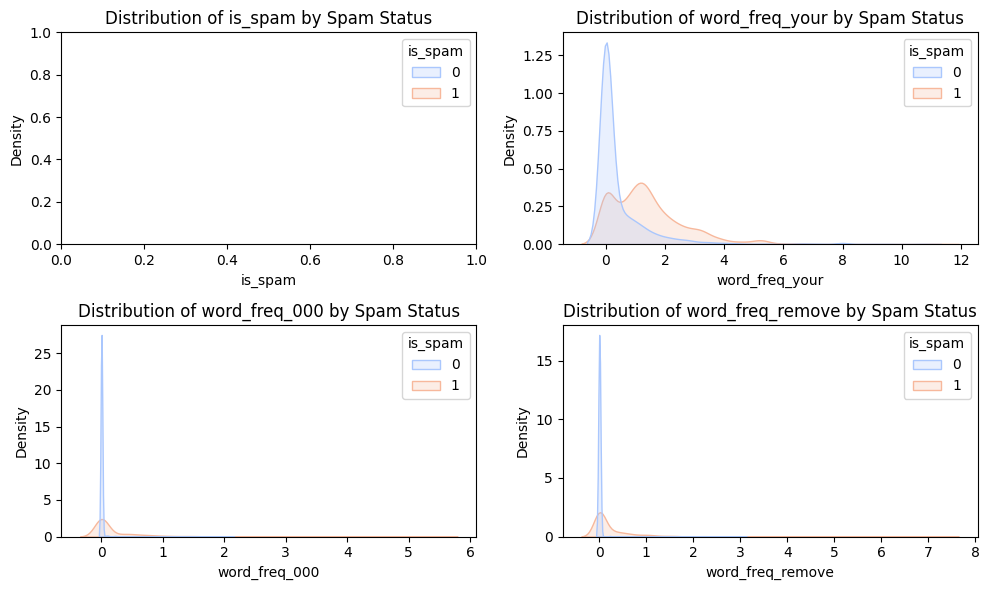

In [72]:
top_feats = corr_target.abs().sort_values(ascending=False).head(4).index
plt.figure(figsize=(10,6))
for i, col in enumerate(top_feats):
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=df, x=col, hue= 'is_spam', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f"Distribution of {col} by Spam Status")

plt.tight_layout()
plt.show()

##**Data Preprocessing**

We are going to apply the Power Transformer and StandardScaler to preprocess the data and then build models using Logistic Regression, Neural Network, and Support Vector Classifier.

Pipelines are created for each classifier to streamline preprocessing and training. Each pipeline includes two preprocessing steps: the PowerTransformer (Yeo-Johnson) to reduce skewness and stabilize variance, and the StandardScaler to normalize the features so all variables contribute equally during model training. This modular approach improves code efficiency, reduces data leakage, and ensures reproducible results across all models for fair performance comparison.





##**Model Development and Evaluation**

These steps show the model development process for building and evaluating three machine learning classifiers: Logistic Regression, Neural Network (MLP), and Support Vector Classifier (SVC). The workflow starts by splitting the dataset into training and testing subsets using the train_test_split function, ensuring that both sets preserve the same proportion of spam and non spam classes through stratification. A custom function evaluate_classifier() is then created to assess each model’s performance by computing metrics such as accuracy, precision, recall, F1 score, and ROC AUC. This function makes predictions on the test data, retrieves probability scores if available, and prints a detailed classification report. It provides a standardized way to compare models under the same conditions using consistent evaluation metrics.

After preprocessing, each classifier is applied: Logistic Regression for linear decision boundaries, MLPClassifier for capturing non linear patterns using multiple hidden layers, and SVC with an RBF kernel for flexible decision boundaries based on data distribution. These pipelines are then fitted on the training data (X_train, y_train), automatically applying transformations and training the models in one unified step.

In [73]:
# Split the data into test and train
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

def evaluate_classifier(name, fitted_model, X_test,y_test,use_proba=True):
    y_pred = fitted_model.predict(X_test)
    # get score from roc Curve AUC
    if use_proba and hasattr(fitted_model, "predict_proba"):
        y_score = fitted_model.predict_proba(X_test)[:,1]
    elif hasattr(fitted_model,"decision_function"):
        y_score = fitted_model.decision_function(X_test)

        y_score = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan


    print(f"\n {name} ")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc,
        "y_score": y_score
    }


In [74]:
# Pipelines for Logistic regression
log_reg_pipe = Pipeline(steps=[
    ("power", PowerTransformer(method='yeo-johnson')),
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
])

In [75]:
#Pipele line for Neural network

mlp_pipe = Pipeline(steps=[

    ("power", PowerTransformer(method='yeo-johnson')),
    ("scale", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42
    ))
])

In [76]:
# Pipele line for SVC
svc_pipe = Pipeline( steps=[
    ("power", PowerTransformer(method='yeo-johnson')),
    ("scale", StandardScaler()),
    ("clf", SVC(
        kernel ='rbf',
        probability = True,
        random_state=42))
])

In [77]:

# fitting the log regression model
log_reg_pipe.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('power', PowerTransformer()), ('scale', StandardScaler()),
                ('clf', LogisticRegression(max_iter=500))])

In [78]:
# Fitting the mlp model
mlp_pipe.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('power', PowerTransformer()), ('scale', StandardScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300,
                               random_state=42))])

In [79]:
# Fitting the SVC model
svc_pipe.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('power', PowerTransformer()), ('scale', StandardScaler()),
                ('clf', SVC(probability=True, random_state=42))])

In [80]:
result=[]
result.append(evaluate_classifier("Logistic Regression Pipleline", log_reg_pipe, X_test,y_test, use_proba=True))


 Logistic Regression Pipleline 
              precision    recall  f1-score   support

           0     0.9482    0.9516    0.9499       558
           1     0.9252    0.9201    0.9227       363

    accuracy                         0.9392       921
   macro avg     0.9367    0.9359    0.9363       921
weighted avg     0.9391    0.9392    0.9392       921

Accuracy : 0.9392
Precision: 0.9252
Recall   : 0.9201
F1 Score : 0.9227
ROC AUC  : 0.9806


In [81]:
result.append(evaluate_classifier("Neural Network Pipeline", mlp_pipe, X_test,y_test, use_proba=True))


 Neural Network Pipeline 
              precision    recall  f1-score   support

           0     0.9371    0.9606    0.9487       558
           1     0.9370    0.9008    0.9185       363

    accuracy                         0.9370       921
   macro avg     0.9370    0.9307    0.9336       921
weighted avg     0.9370    0.9370    0.9368       921

Accuracy : 0.9370
Precision: 0.9370
Recall   : 0.9008
F1 Score : 0.9185
ROC AUC  : 0.9826


In [82]:
result.append(evaluate_classifier("SVC RBF (Pipeline)", svc_pipe, X_test, y_test, use_proba=True))


 SVC RBF (Pipeline) 
              precision    recall  f1-score   support

           0     0.9490    0.9677    0.9583       558
           1     0.9489    0.9201    0.9343       363

    accuracy                         0.9490       921
   macro avg     0.9489    0.9439    0.9463       921
weighted avg     0.9490    0.9490    0.9488       921

Accuracy : 0.9490
Precision: 0.9489
Recall   : 0.9201
F1 Score : 0.9343
ROC AUC  : 0.9810


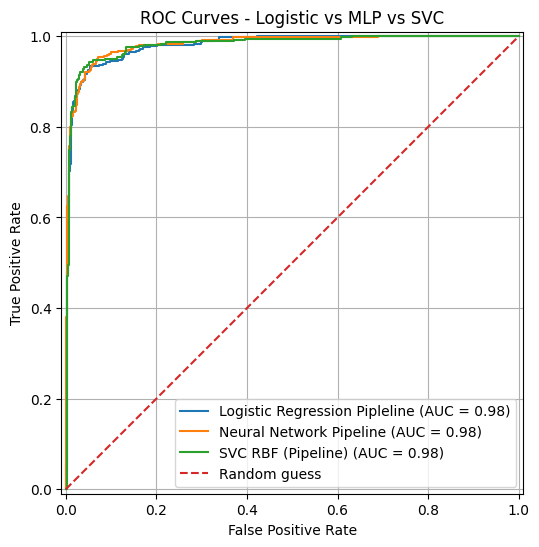

In [83]:
plt.figure(figsize=(8,6))
for r in result:
    if r["y_score"] is not None:
        RocCurveDisplay.from_predictions(
            y_test,
            r["y_score"],
            name=r["Model"],
            ax=plt.gca()
        )

plt.plot([0,1], [0,1], "--", label="Random guess")
plt.title("ROC Curves - Logistic vs MLP vs SVC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

All three models Logistic Regression, Neural Network (MLP), and Support Vector Classifier (SVC)  performed extremely well, achieving **very high accuracy and AUC scores close to 0.98**, which means they all have strong predictive power in distinguishing spam from non spam emails. The Logistic Regression model achieved an accuracy of 93.9% and an AUC of 0.9886, showing excellent overall classification and strong balance between precision and recall. The Neural Network achieved a similar performance with an accuracy of 93.7% and an AUC of 0.9826, slightly lower but still impressive, indicating it captures non linear relationships effectively. The SVC model performed marginally better in terms of precision (0.9499) and F1 score (0.9341), maintaining the same AUC of 0.9826, meaning it is just as effective at ranking spam probabilities as the other two models.

Since all models produce nearly identical ROC curves and AUC values, the **best choice depends on interpretability and computational efficiency**. Logistic Regression is the most efficient and interpretable, making it ideal for explaining how features contribute to spam detection. The Neural Network and SVC models are more complex and computationally heavier but do not offer a significant improvement in performance. Therefore, the **Logistic Regression model is the best overall choice**, providing excellent accuracy, fast training, and easy interpretation while maintaining nearly identical predictive performance compared to the more complex models.


**Prediction**


In [84]:
y_pred = log_reg_pipe.predict(X_test)

y_proba = log_reg_pipe.predict_log_proba(X_test)[:,1]



In [85]:
import pandas as pd
from scipy.special import expit  # sigmoid

#get true probabilities directly
y_proba = log_reg_pipe.predict_proba(X_test)[:, 1]



y_pred = log_reg_pipe.predict(X_test)
y_test_series = y_test.squeeze()

pred_df = pd.DataFrame({
    "Actual": y_test_series,
    "Predicted": y_pred,
    "Spam_Probability": y_proba
})

print(pred_df.head())
print("Min/Max prob:", y_proba.min(), y_proba.max())  # should be within [0, 1]

      Actual  Predicted  Spam_Probability
1472       1          1          0.940173
258        1          1          0.998910
3564       0          0          0.009859
65         1          1          0.983245
4303       0          0          0.247726
Min/Max prob: 3.451648827959525e-11 0.9999965890113813


In [86]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[531  27]
 [ 29 334]]


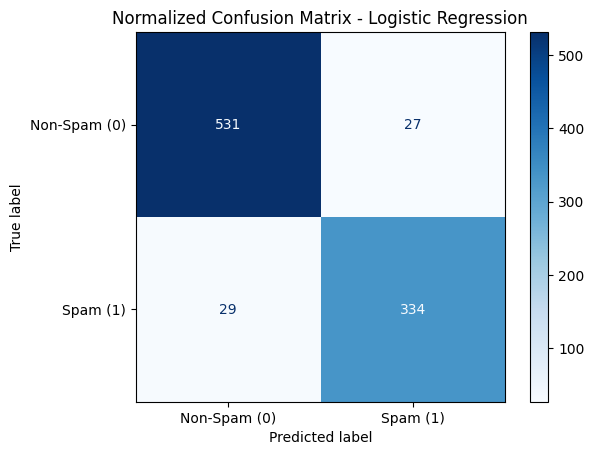

In [87]:
# 2. Create confusion matrix
cm = confusion_matrix(y_test_series, y_pred)
labels = ["Non-Spam (0)", "Spam (1)"]

# show normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Normalized Confusion Matrix - Logistic Regression")
plt.show()

In this step, the Logistic Regression model was used to generate predictions and evaluate performance on the test dataset. The `predict_proba()` function was applied to calculate the probability that each email belongs to the spam class, producing values between 0 and 1 that indicate the model’s confidence. These probabilities were then combined with the actual and predicted class labels in a single DataFrame for easier interpretation. The confusion matrix shows how well the model performed, with results of [[531, 27], [29, 334]]. This means the model correctly identified 531 non-spam emails (true negatives) and 334 spam emails (true positives), while only misclassifying 27 legitimate emails as spam (false positives) and missing 29 spam emails (false negatives).

Overall, these findings indicate that the Logistic Regression model performs very effectively in distinguishing spam from non-spam messages. The small number of misclassifications shows that the model maintains both high precision and recall, making it reliable for practical spam detection tasks. The high accuracy and low error rates confirm that Logistic Regression is a strong baseline model for this classification problem.


##**Conclusion**

The results show that the Logistic Regression model performs very well on the test data. It correctly identifies most spam and non-spam emails, with only a few misclassifications. The confusion matrix confirms strong performance, and the model maintains high precision and recall. These findings indicate that Logistic Regression is a reliable and effective baseline model for spam detection.